In [1]:
import torch
from cirkit.templates import data_modalities, utils

KERNEL_SIZE=(4,4)
STRIDE=KERNEL_SIZE
gpu_id=7

## Data Setup

torch.Size([3, 32, 32])


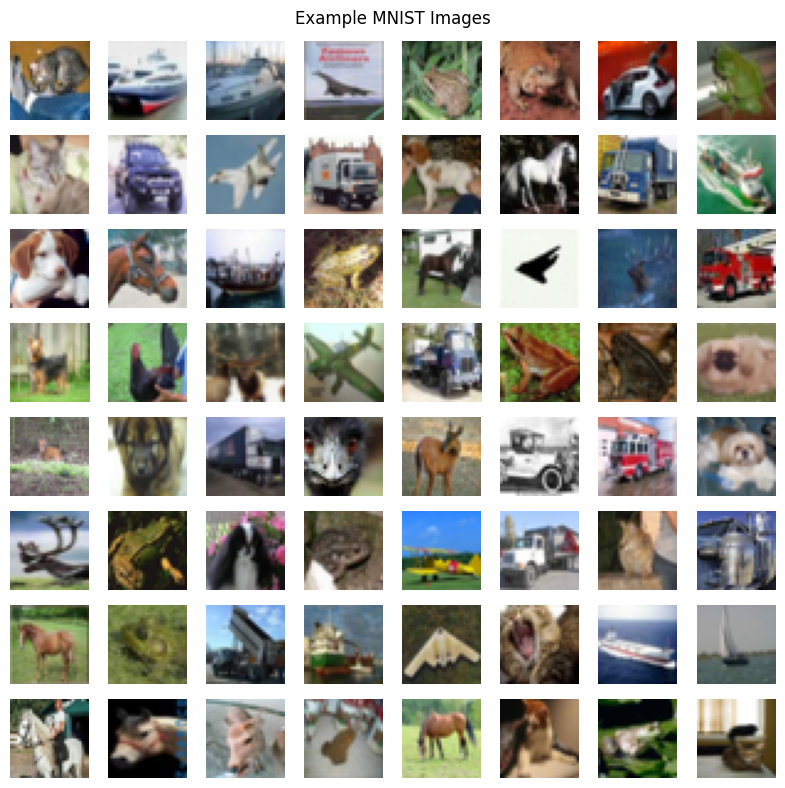

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from torchvision import transforms, datasets

PIXEL_RANGE=255
# Store an example image
example_image = None


def patchify(kernel_size, stride,compile=True, contiguous_output=False):
    kh, kw = (kernel_size, kernel_size) if isinstance(kernel_size, int) else kernel_size
    sh, sw = (stride, stride) if isinstance(stride, int) else stride
    def _patchify(image: torch.Tensor):
        # Accept (C,H,W) or (B,C,H,W)

        # Ensure contiguous NCHW for predictable strides
        x = image.contiguous()  # (B,C,H,W)
        B, C, H, W = x.shape

        # Number of patches along H/W
        Lh = (H - kh) // sh + 1
        Lw = (W - kw) // sw + 1

        # Create a zero-copy view: (B, C, Lh, Lw, kh, kw)
        sN, sC, sH, sW = x.stride()
        patches = x.as_strided(
            size=(B, C, Lh, Lw, kh, kw),
            stride=(sN, sC, sH * sh, sW * sw, sH, sW),
        )
        # Reorder to (B, P, C, kh, kw) where P = Lh*Lw
        patches = patches.permute(0, 2, 3, 1, 4, 5).reshape(B, Lh * Lw, C, kh, kw)

        if contiguous_output:
            patches = patches.contiguous()  # materialize if the next ops need contiguous

        return patches
    if compile:
        _patchify = torch.compile(_patchify, fullgraph=True, dynamic=False)
    return _patchify


# Load the MNIST data set and data loaders
transform = transforms.Compose([
    transforms.ToTensor(),
    # Set pixel values in the [0-255] range
    transforms.Lambda(lambda x: (PIXEL_RANGE * x).long()),

])

# Function to plot the first 9 images from the dataloader
def plot_sample_images(dataloader, gridsize=4):
    global example_image
    # Get the first batch of images and labels
    images, label = next(iter(dataloader))
    example_image = images[0]
    print(example_image.shape)
    images = images[:gridsize**2]
    
    # Create a 3x3 subplot
    fig, axes = plt.subplots(gridsize, gridsize, figsize=(8, 8))
    
    # Plot each image
    for i, ax in enumerate(axes.flat):
        # Convert the image to a 2D array (since MNIST images are 28x28 pixels)
        img = images[i,:,:,:].numpy().squeeze().transpose((1,2,0))

        # Display the image
        ax.imshow(img)
        ax.axis('off')  # Turn off axis
    
    # Adjust spacing between subplots
    fig.suptitle('Example MNIST Images')
    plt.tight_layout()
    plt.show()


data_train = datasets.CIFAR10('datasets', train=True, download=True, transform=transform)
data_test = datasets.CIFAR10('datasets', train=False, download=True, transform=transform)

# Instantiate the training and testing data loaders
train_dataloader = DataLoader(data_train, shuffle=True, batch_size=256,)
test_dataloader = DataLoader(data_test, shuffle=False, batch_size=256,)
# Call the function to plot images
plot_sample_images(test_dataloader, gridsize=8)

In [20]:
circuit = data_modalities.image_data(
    (3,*KERNEL_SIZE),
    region_graph="quad-graph",
    input_layer="categorical",
    num_input_units=64,
    sum_product_layer="cp-t",
    num_sum_units=64,
    sum_weight_param=utils.Parameterization(
            activation='softmax',   
            initialization='normal' 
        )
)
circuit

In [21]:
from cirkit.pipeline import compile

c_circuit = compile(circuit)

In [24]:
import random




def train_circuit(circuit):

    # Set some seeds
    random.seed(42)
    np.random.seed(42)
    torch.manual_seed(42)
    # torch.cuda.manual_seed(42)
    
    # Set the torch device to use
    device = torch.device(f'cuda:{gpu_id}')

    
    # Move the circuit to chosen device
    circuit = circuit.to(device)
    
    num_epochs = 1
    step_idx = 0
    running_loss = 0.0
    running_samples = 0
    stats = dict()

    stats['# trainable parameters'] = sum(p.numel() for p in circuit.parameters() if p.requires_grad)
    stats['train loss'] = []
    
    # Initialize a torch optimizer of your choice,
    #  e.g., Adam, by passing the parameters of the circuit
    optimizer = torch.optim.Adam(circuit.parameters(), lr=0.01)
    patch_fn = patchify(KERNEL_SIZE, STRIDE),
    
    for epoch_idx in range(num_epochs):
        for i, (batch, _) in enumerate(train_dataloader):
            # The circuit expects an input of shape (batch_dim, num_variables)
            BS = batch.shape[0]
            batch = patch_fn(batch)
            batch = batch.view(BS, -1).to(device)
    
            # Compute the log-likelihoods of the batch, by evaluating the circuit
            log_likelihoods = circuit(batch)
    
            # We take the negated average log-likelihood as loss
            loss = -torch.mean(log_likelihoods)
            loss.backward()
            # Update the parameters of the circuits, as any other model in PyTorch
            optimizer.step()
            optimizer.zero_grad()
            running_loss += loss.detach() * len(batch)
            running_samples += len(batch)
            step_idx += 1
            if step_idx % 200 == 0:
                average_nll = running_loss / running_samples
                print(f"Step {step_idx}: Average NLL: {average_nll:.3f}")
                running_loss = 0.0
                running_samples = 0
                
                stats['train loss'].append(average_nll.cpu().item())
    return stats, circuit


stats, c_circuit = train_circuit(c_circuit)
stats

TypeError: 'function' object is not subscriptable

In [58]:
def eval_circuit(circuit):
    circuit = circuit.to(f"cuda:{gpu_id}")
    with torch.no_grad():
        test_lls = 0.0
    
        for batch, _ in test_dataloader:
            # The circuit expects an input of shape (batch_dim, num_variables)
            BS = batch.shape[0]
            # (BxP,C,H,W) -> # (B,P,C,H,W)
            batch = batch.view(BS, -1).to(f"cuda:{gpu_id}")
            # Compute the log-likelihoods of the batch
            log_likelihoods = circuit(batch)
    
            # Accumulate the log-likelihoods
            test_lls += log_likelihoods.sum().item()
    
        # Compute average test log-likelihood and bits per dimension
        average_nll = - test_lls / len(data_test)

        bpd = average_nll / (32 * 32*3 * np.log(2.0))
        print(f"Average test LL: {average_nll:.3f}")
        print(f"Bits per dimension: {bpd:.3f}")
        
        stats['test loss'] = average_nll
        stats['test bits per dimension'] = bpd

    # Free GPU memory
    circuit = circuit.to('cpu')
    torch.cuda.empty_cache()

    stats['train loss (min)'] = min(stats['train loss'])
    return stats
eval_circuit(c_circuit)

Average test LL: 12649.619
Bits per dimension: 5.941


{'# trainable parameters': 901762,
 'train loss': [197.58175659179688,
  197.5917510986328,
  197.52992248535156,
  197.5257110595703,
  197.47073364257812,
  197.5422821044922,
  197.50360107421875,
  197.46804809570312,
  197.4739990234375],
 'test loss': 12649.619428125,
 'test bits per dimension': np.float64(5.94060651630489),
 'train loss (min)': 197.46804809570312}

In [44]:
def eval_circuit(circuit):
    circuit = circuit.to(f"cuda:{gpu_id}")
    with torch.no_grad():
        test_lls = 0.0
    
        for batch, _ in test_dataloader:
            # The circuit expects an input of shape (batch_dim, num_variables)
            BS = batch.shape[0]
            # (BxP,C,H,W) -> # (B,P,C,H,W)
            batch = batch.view(BS, -1).to(f"cuda:{gpu_id}")
            # Compute the log-likelihoods of the batch
            log_likelihoods = circuit(batch)
    
            # Accumulate the log-likelihoods
            test_lls += log_likelihoods.sum().item()
    
        # Compute average test log-likelihood and bits per dimension
        average_nll = - test_lls / len(data_test)

        bpd = average_nll / (32 * 32 *3 * np.log(2.0))
        print(f"Average test LL: {average_nll:.3f}")
        print(f"Bits per dimension: {bpd:.3f}")
        
        stats['test loss'] = average_nll
        stats['test bits per dimension'] = bpd

    # Free GPU memory
    circuit = circuit.to('cpu')
    torch.cuda.empty_cache()

    stats['train loss (min)'] = min(stats['train loss'])
    return stats
eval_circuit(c_circuit)

Average test LL: 12970.730
Bits per dimension: 6.091


{'# trainable parameters': 901762,
 'train loss': [245.8564910888672,
  215.6695556640625,
  208.15460205078125,
  204.7366485595703],
 'test loss': 12970.729903125,
 'test bits per dimension': np.float64(6.09140875909786),
 'train loss (min)': 204.7366485595703}

In [11]:
import cProfile
cProfile.run('train_circuit(c_circuit)')

         7205562 function calls (7185751 primitive calls) in 14.206 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
    50000    0.425    0.000    1.751    0.000 2614646838.py:15(_patchify)
      196    0.007    0.000    0.580    0.003 2614646838.py:54(collate_patches)
      196    0.003    0.000    0.003    0.000 2614646838.py:67(<listcomp>)
      196    0.182    0.001    0.182    0.001 2614646838.py:71(<listcomp>)
    50000    0.537    0.000    0.826    0.000 2614646838.py:82(<lambda>)
        8    0.000    0.000    0.000    0.000 269727123.py:30(<genexpr>)
        1    0.056    0.056   14.215   14.215 269727123.py:9(train_circuit)
    50812    0.046    0.000    0.061    0.000 <frozen importlib._bootstrap>:1053(_handle_fromlist)
    50000    0.032    0.000    0.049    0.000 <frozen importlib._bootstrap>:404(parent)
        1    0.000    0.000   14.215   14.215 <string>:1(<module>)
      784    0.002    0.000    0.005    0

In [16]:
import cProfile
cProfile.run('train_circuit(c_circuit)')

         15657858 function calls (15388071 primitive calls) in 20.212 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        8    0.000    0.000    0.000    0.000 269727123.py:30(<genexpr>)
        1    0.043    0.043   20.221   20.221 269727123.py:9(train_circuit)
    50000    0.119    0.000    5.635    0.000 3039285227.py:15(_patchify)
      196    0.008    0.000    0.572    0.003 3039285227.py:56(collate_patches)
      196    0.003    0.000    0.003    0.000 3039285227.py:69(<listcomp>)
      196    0.181    0.001    0.181    0.001 3039285227.py:73(<listcomp>)
    50000    0.757    0.000    1.061    0.000 3039285227.py:84(<lambda>)
    50784    0.051    0.000    0.066    0.000 <frozen importlib._bootstrap>:1053(_handle_fromlist)
    50000    0.034    0.000    0.051    0.000 <frozen importlib._bootstrap>:404(parent)
        1    0.000    0.000   20.221   20.221 <string>:1(<module>)
      784    0.002    0.000    0.006   

In [6]:
patch_fn,=    patchify(KERNEL_SIZE, STRIDE),

cProfile.run('patch_fn(example_image)')

NameError: name 'cProfile' is not defined